In [1]:
 
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Input, LSTM, RepeatVector
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.optimizers import SGD, RMSprop, Adam
from keras import objectives


Using TensorFlow backend.
/home/arjun/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/arjun/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/arjun/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/arjun/.local/lib/python3.6/site-packages/tensorflow/python/fra

In [1]:
import h5py
import random
class Miir():
    def __init__(self, data_path='/home/arjun/PycharmProjects/untitled3/openmiir-rl-2016/EEG-Disetangled-Classification-master/OpenMIIR-Perception-512Hz.hdf5', train=True):
        h5 = h5py.File(data_path, 'r')
        self.train = train
        features = h5['features']
        targets = h5['targets']
        subjects = h5['subjects']
        train_indx=[]
        self.train_features=[]
        self.test_features=[]
        self.train_targets = []
        self.test_targets = []
        self.train_subjects = self.test_subjects=[]
        self.test_subject_id = random.randint(0,8)
        for i,e in enumerate(subjects):
            if e != self.test_subject_id:
                train_indx.append(i)
        for i, e in enumerate(features):
            if i in train_indx:
                self.train_features.append(e)
            if i not in train_indx:
                self.test_features.append(e)
        for i, e in enumerate(targets):
            if i in train_indx:
                self.train_targets.append(e)
            if i not in train_indx:
                self.test_targets.append(e)
        for i, e in enumerate(subjects):
            if i in train_indx:
                self.train_subjects.append(e)
            if i not in train_indx:
                self.test_subjects.append(e)
        self.train_size = len(self.train_features)
        self.test_size = len(self.test_features)
    
    def __len__(self):
        if self.train:
            return self.train_size
        else:
            return self.test_size

    def __getitem__(self, index):
        if self.train:
            return self.train_features[index], self.train_targets[index], self.train_subjects[index]
        else:
            return self.test_features[index], self.test_targets[index], self.test_subjects[index]



In [2]:
class_miir = Miir()

In [3]:
import numpy as np
work_train = np.squeeze(np.array(class_miir.train_features))

In [4]:

import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Input, LSTM, RepeatVector
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.optimizers import SGD, RMSprop, Adam
from keras import objectives


def create_lstm_vae(input_dim, 
    timesteps, 
    batch_size, 
    intermediate_dim, 
    latent_dim,
    epsilon_std=1.):


    x = Input(shape=(timesteps, input_dim,))

    h = LSTM(intermediate_dim)(x)

    z_mean = Dense(latent_dim)(h)
    z_log_sigma = Dense(latent_dim)(h)
    
    def sampling(args):
        z_mean, z_log_sigma = args
        epsilon = K.random_normal(shape=(batch_size, latent_dim),
                                  mean=0., stddev=epsilon_std)
        return z_mean + z_log_sigma * epsilon

    z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])
    
    decoder_h = LSTM(intermediate_dim, return_sequences=True)
    decoder_mean = LSTM(input_dim, return_sequences=True)

    h_decoded = RepeatVector(timesteps)(z)
    h_decoded = decoder_h(h_decoded)

    x_decoded_mean = decoder_mean(h_decoded)
    vae = Model(x, x_decoded_mean)

    encoder = Model(x, z_mean)

    decoder_input = Input(shape=(latent_dim,))

    _h_decoded = RepeatVector(timesteps)(decoder_input)
    _h_decoded = decoder_h(_h_decoded)

    _x_decoded_mean = decoder_mean(_h_decoded)
    generator = Model(decoder_input, _x_decoded_mean)
    
    def vae_loss(x, x_decoded_mean):
        xent_loss = objectives.mse(x, x_decoded_mean)
        kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma))
        loss = xent_loss + kl_loss
        return loss

    vae.compile(optimizer='rmsprop', loss=vae_loss)
    
    return vae, encoder, generator

Using TensorFlow backend.
/home/arjun/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/arjun/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/arjun/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/arjun/.local/lib/python3.6/site-packages/tensorflow/python/fra

In [ ]:
if __name__ == "__main__":

    input_dim = work_train.shape[-1] # 13

    timesteps = work_train.shape[1] # 3
    batch_size = 1

    vae, enc, gen = create_lstm_vae(input_dim, 
        timesteps=timesteps, 
        batch_size=batch_size, 
        intermediate_dim=100,
        latent_dim=32,
        epsilon_std=1.)

    vae.fit(work_train, work_train, epochs=100)

    preds = vae.predict(work_train, batch_size=batch_size)

    print("[plotting...]")
    #print("x: %s, preds: %s" % (x.shape, preds.shape))
    plt.plot(work_train[:,0,3], label='data')
    plt.plot(preds[:,0,3], label='predict')
    plt.legend()
    plt.show()
    plt.savefig('lstmvae.png')

Epoch 1/400
480/480 [==============================] - 9s 20ms/step - loss: 0.0539
Epoch 2/400
480/480 [==============================] - 9s 20ms/step - loss: 0.0533
Epoch 3/400
480/480 [==============================] - 9s 20ms/step - loss: 0.0535
Epoch 4/400
480/480 [==============================] - 9s 20ms/step - loss: 0.0539
Epoch 5/400
480/480 [==============================] - 10s 20ms/step - loss: 0.0547
Epoch 6/400
480/480 [==============================] - 10s 20ms/step - loss: 0.0538
Epoch 7/400
480/480 [==============================] - 9s 20ms/step - loss: 0.0531
Epoch 8/400
480/480 [==============================] - 9s 20ms/step - loss: 0.0532
Epoch 9/400
480/480 [==============================] - 9s 20ms/step - loss: 0.0544
Epoch 10/400
480/480 [==============================] - 9s 20ms/step - loss: 0.0528
Epoch 11/400
480/480 [==============================] - 9s 20ms/step - loss: 0.0515
Epoch 12/400
480/480 [==============================] - 9s 20ms/step - loss: 0.0512

[plotting...]


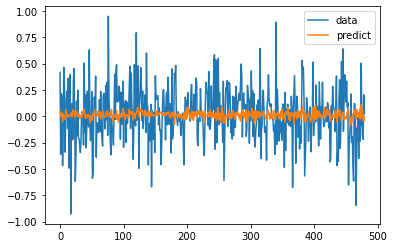

<Figure size 432x288 with 0 Axes>

In [14]:
import matplotlib.pyplot as plt
preds = vae.predict(work, batch_size=batch_size)

# pick a column to plot.
print("[plotting...]")
#print("x: %s, preds: %s" % (x.shape, preds.shape))
plt.plot(work_train[:,0,3], label='data')
plt.plot(preds[:,0,3], label='predict')
plt.legend()
plt.show()
plt.savefig('lstmvae.png')

In [11]:
import numpy as np
work_test = np.squeeze(np.array(class_miir.test_features))

In [65]:
np.save('preds',preds)

In [12]:
preds_test = vae.predict(work_test, batch_size=batch_size)

In [13]:
np.save('preds',preds)
np.save('preds_test',preds_test)
np.save('work',work_train)
np.save('work_test',work_test)

In [9]:
import matplotlib.pyplot as plt


In [7]:
import numpy as np
preds_test = np.load('preds_test.npy')
preds = np.load('preds.npy')
work_test = np.load('work_test.npy')
work = np.load('work.npy')

[plotting...]


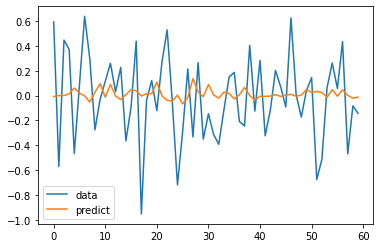

<Figure size 432x288 with 0 Axes>

In [14]:
# pick a column to plot.
print("[plotting...]")
#print("x: %s, preds: %s" % (x.shape, preds.shape))
plt.plot(work_test[:,0,3], label='data')
plt.plot(preds_test[:,0,3], label='predict')
plt.legend()
plt.show()
plt.savefig('lstmvae_test.png')